# Data download and Library installation


In [ ]:
!pip install gdown
!gdown --id 1KsOjBR_NkRTCs9cGke49q3JrjbZbWTP5
!unzip train3.zip
!mkdir input

Streaming output truncated to the last 5000 lines.
  inflating: train_out_20/020_140_002  
  inflating: train_out_20/020_140_003  
  inflating: train_out_20/020_140_004  
  inflating: train_out_20/020_140_005  
  inflating: train_out_20/020_140_006  
  inflating: train_out_20/020_140_007  
  inflating: train_out_20/020_140_008  
  inflating: train_out_20/020_140_009  
  inflating: train_out_20/020_140_010  
  inflating: train_out_20/020_140_011  
  inflating: train_out_20/020_140_012  
  inflating: train_out_20/020_140_013  
  inflating: train_out_20/020_140_014  
  inflating: train_out_20/020_140_015  
  inflating: train_out_20/020_140_016  
  inflating: train_out_20/020_140_017  
  inflating: train_out_20/020_140_018  
  inflating: train_out_20/020_140_019  
  inflating: train_out_20/020_140_020  
  inflating: train_out_20/020_140_021  
  inflating: train_out_20/020_140_022  
  inflating: train_out_20/020_140_023  
  inflating: train_out_20/020_140_024  
  inflating: train_out_20/020

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q scipy --upgrade
!pip install dgl-cu118 dglgo -f https://data.dgl.ai/wheels/repo.html

2.0.0+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
ERROR: Could not find a version that satisfies the requirement dgl-cu118 (from versions: none)
ERROR: No matching distribution found for dgl-cu118


In [ ]:
import numpy as np
from numpy.linalg import eigh
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import dgl
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import itertools
import numpy as np
import dgl.function as fn
import dgl.nn as dglnn
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Helper functions

In [ ]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    if pad_width[1] != 0:                      # <-- the only change (0 indicates no padding)
        vector[-pad_width[1]:] = pad_value

In [ ]:
def getSource(graph_name):
    # File open
    f = open(graph_name + ".graph", "r")
    # Graph init
    g = nx.Graph()
    n, m = [int(i) for i in f.readline().split(" ")]
    src = []
    dst = []
    for i in range(n):
        for j in f.readline().split(" "):
            src.append(i)
            dst.append(int(j) - 1)
            g.add_edge(i, int(j) - 1)
    # Conversion
    data = dgl.graph((torch.tensor(src), torch.tensor(dst)))
    # Eigen Decomp
    adj_matrix = nx.adjacency_matrix(g).toarray()
    eigen_values, eigen_vectors = eigh(adj_matrix)
    idx = np.abs(eigen_values).argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    eigen_vectors = eigen_vectors[:, -20:]
    data.ndata['feature'] = torch.from_numpy(eigen_vectors).double()
    return data

In [ ]:
def readLsp(graph_name):
    # File open
    f = open(graph_name, "r")
    # formatting
    f.readline()
    lst = []
    for i in f.readline().split(" "):
        if i != '\n':
            lst.append(int(i))
    return lst

In [ ]:
def getEdgeLabel(graph_name, edge_index):
    lst = readLsp(graph_name)
    y = np.zeros((len(edge_index[0]),1), dtype=np.int32)
    st = set()
    for i in range(1, len(lst)):
        st.add((lst[i - 1] - 1, lst[i] - 1))
        st.add((lst[i] - 1, lst[i - 1] - 1))
    cnt = 0
    for i in range(len(edge_index[0])):
        if (int(edge_index[0][i]), int(edge_index[1][i])) in st:
            cnt += 1
            y[i][0] = 1
    
    return torch.from_numpy(y).double()

In [ ]:
def getEdgeFeature(data):
    res = np.zeros((len(data.edges()[0]), 20))
    for i in range(len(data.edges()[0])):
        u = int(data.edges()[0][i])
        v = int(data.edges()[1][i])
        res[i] = np.mean([data.ndata['feature'][u].numpy(), data.ndata['feature'][v].numpy()])
    return torch.from_numpy(res).double()

# Model

In [ ]:
class GNN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = dglnn.GraphConv(in_feats=hid_feats, out_feats=hid_feats)
        self.conv3 = dglnn.GraphConv(in_feats=hid_feats, out_feats=out_feats)

    def forward(self, graph, inputs):
        # inputs are features of nodes 
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv3(graph, h)
        return h

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(h_u +  h_v)
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h.double()
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_features_2, out_classes):
        super().__init__()
        self.sage = GNN(in_features, hidden_features, hidden_features_2)
        self.pred = MLPPredictor(hidden_features_2, out_classes)
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

# Dataset

In [ ]:
class LSPDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='lsp')

    def process(self):
        self.graphs = []

        for i in range(19,191):
            for j in range(100 if i < 190 else 1):
                graph_number =  "020_" + str(i).zfill(3) + "_" + str(j).zfill(3)
                data = getSource('train_in_20/' + graph_number)
                data.edata['label'] = getEdgeLabel('train_out_20/' + graph_number, data.edges()).double()
                data.edata['feature'] = getEdgeFeature(data).double()
                self.graphs.append(data)
            if(i%10 == 0):
                print(i)

    def __getitem__(self, i):
        return self.graphs[i]

    def __len__(self):
        return len(self.graphs)

In [ ]:
dataset = LSPDataset()

20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [ ]:
len(dataset)

17101

In [ ]:
total_length = 0
total_sum = 0
for i in range(len(dataset)):
    x = dataset[i].edata['label']
    total_sum += sum(x)
    total_length += len(x)

In [ ]:
(1-total_sum/total_length).detach().cpu().numpy()[0]

0.8203054104655936

In [ ]:
num_examples = len(dataset)
num_train = int(num_examples * 0.9)
num_train

15390

In [ ]:
torch.manual_seed(379238328)
all_range = torch.randperm(num_examples)
train_sampler = SubsetRandomSampler(all_range[0: num_train])
test_sampler = SubsetRandomSampler(all_range[num_train: num_examples])

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=16000, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=1800, drop_last=False)

# Training

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cuda', index=0)

In [ ]:
model = Model(20, 32, 16, 1)

In [ ]:
model = model.double()
model = model.train()
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(500):
    for batched_graph in train_dataloader:
        batched_graph = batched_graph.to(device)
        node_features = batched_graph.ndata['feature'].double()
        edge_label = batched_graph.edata['label'].double()
        node_features = node_features.double()
        pred = model(batched_graph, node_features)
        loss = torch.mean(torch.add(3 * edge_label, 1) * (pred - edge_label)**2)
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(loss.item())

0.6338885743644371
0.49730735261975395
0.4051156588507349
0.3816763985802805
0.4281254800869555
0.42255669532722545
0.3947227377078849
0.3773411635199213
0.37451753803850235
0.3790378367483783
0.3841181647813389
0.38633816869405585
0.3848773769248673
0.3806317447075598
0.37540639734960385
0.3712741941364939
0.3698204362296681
0.37101624522674415
0.372404888979204
0.3716181335510904
0.36875120704266345
0.36545400753974244
0.3630487956598612
0.36185345495468535
0.3613810807608199
0.36090108770067525
0.35990567876207324
0.35837241615710397
0.35682813051283646
0.35607633438919334
0.3563866019566655
0.35685616945782694
0.3565024471572966
0.3556557293869402
0.355260212218629
0.3555503350102619
0.3560197636987683
0.3561545915776665
0.35587879800804284
0.3555055595620537
0.3553837637832851
0.35551745016049774
0.35556684023650476
0.3553156895491118
0.3549390499403687
0.35471141684372837
0.3546802114705336
0.3546959129528137
0.3546234016182932
0.3544648995517079
0.3543238328227381
0.354284626843

In [ ]:
torch.save(model.state_dict(), "bruh.model")

# Testing

In [ ]:
model.eval()
for batched_graph in test_dataloader:
        batched_graph = batched_graph.to(device)
        node_features = batched_graph.ndata['feature'].double()
        edge_label = batched_graph.edata['label'].double()
        node_features = node_features.double()
        pred = model(batched_graph, node_features)
        loss = pred - edge_label

In [ ]:
matches = (pred.detach().cpu().numpy()>0.5) == (edge_label.detach().cpu().numpy()==1)

In [ ]:
np.sum(matches)/len(matches)

0.7444132973131832

In [ ]:
1 - np.abs(loss.detach().cpu().numpy()).mean()

0.5791587457204377

In [ ]:
BEAM_WIDTH = 5

def beam_search(graph, pred):
    pred = pred.detach().cpu().numpy()
    edges = graph.edges()
    # pred = np.random.rand(len(edges[0]))
    adj = [[] for i in range(graph.number_of_nodes())]
    for i in range(len(edges[0])):
        adj[int(edges[0][i])].append((int(edges[1][i]), i))
    tot_lsp = 0
    tot_path = []
    for s in range(graph.number_of_nodes()):
        msk = [0] * graph.number_of_nodes()
        msk[s] = 1
        cand = [(1, msk, s)]
        lsp = 1
        while len(cand) > 0:
            lsp += 1
            # print(lsp)
            ncand = []
            for p, msk, u in cand:
                # print(' ', p, msk, u)
                for v, i in adj[u]:
                    if msk[v] > 0:
                        continue
                    nmsk = msk.copy()
                    nmsk[v] = lsp
                    newp = p * float(pred[i])
                    # print('  ', v)
                    if len(ncand) < BEAM_WIDTH:
                        ncand.append((newp, nmsk, v))
                    else:
                        cur = 0
                        for i in range(BEAM_WIDTH):
                            if ncand[i][0] < ncand[cur][0]:
                                cur = i
                        if newp > cur:
                            ncand[cur] = (newp, nmsk, v)
            if len(ncand) == 0:
                lsp -= 1
                break
            cand = ncand
        if tot_lsp < lsp:
            tot_lsp = lsp
            tot_path = [-1] * lsp
            for i in range(graph.number_of_nodes()):
                if cand[0][1][i] > 0:
                    tot_path[cand[0][1][i] - 1] = i
    return tot_path

In [ ]:
acc = 0
for i in all_range[num_train: num_examples]:
    graph = dataset[i].to(device)
    node_features = graph.ndata['feature'].double()
    edge_label = graph.edata['label'].int()
    pred = model(graph, node_features)
    true_lsp = int(torch.count_nonzero(edge_label)) // 2 + 1
    pred_lsp = beam_search(graph, pred)
    acc += len(pred_lsp) / true_lsp
acc /= num_examples - num_train
acc

0.9940346116385617

0


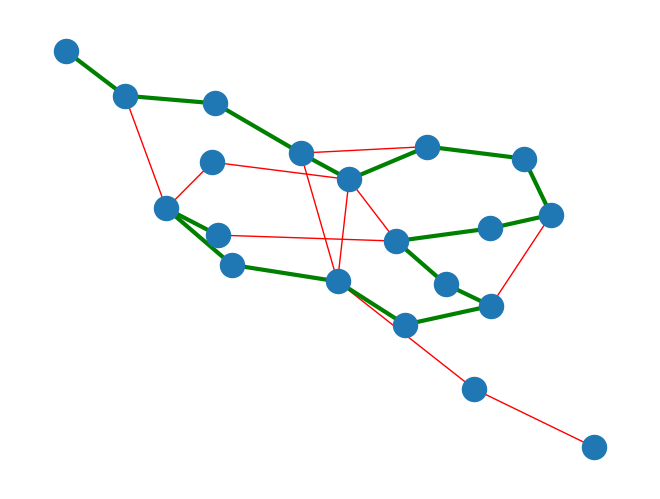

In [ ]:
test = dataset[897]
graph = test.to(device)
node_features = graph.ndata['feature'].double()
edge_label = graph.edata['label'].int()
pred = model(graph, node_features)
true_lsp = int(torch.count_nonzero(edge_label)) // 2 + 1
pred_lsp = beam_search(graph, pred)
G = dgl.to_networkx(test).to_undirected()
edges = G.edges()
for u, v in edges:
    G[u][v][0]['colour'] = "r"
    G[u][v][0]['weight'] = 1
for i in range(len(pred_lsp) - 1):
    G[pred_lsp[i]][pred_lsp[i+1]][0]['colour'] = "g"
    G[pred_lsp[i]][pred_lsp[i+1]][0]['weight'] = 3
colours = [G[u][v][0]['colour'] for u,v in edges]
weights = [G[u][v][0]['weight'] for u,v in edges]
print(len(pred_lsp) - true_lsp)
nx.draw(G, pos = nx.spring_layout(G, seed = 267), edge_color = colours, width = weights)